# Muon Separator Voltage Signal Exploration Pre Capacitor

In this notebook we explore the raw voltage signal. This data was sampled with the frequencey at 1000Hz and the number of elements at 100 so the DAQ sent a packet of 100 readings to the IOC every 0.1 seconds. 

The aim is to see how noisy the data is and if their is a 50Hz component. The data was taken before a 0.1uF capacitor was fitted so will be extra noisy. More analysis will be need of data post fitting the capacitor.

In [1]:
import numpy as np
import altair as alt
import os
import pandas as pd

from src.data_processing import create_data_from_entry, calibrate_data
from src.vizualization import LINE_COLOUR

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

%load_ext autoreload
%autoreload 2

## Cleaning the data

The raw data takes the following form:

- Column 0: Time since EPOCH the reading was taken given by the python collection script `Muon-data-logger.py`.
- Column 1-100: Data from the `DAQ:_RAW` record. The readings are the DAQ voltage readings. These readings were requested every 0.05 seconds by the python script collecting the data from the IOC.

In [2]:
raw = pd.read_csv("..\\data\\raw\\muon_results.csv", nrows=36000, header=None)

Now we clean the data up by changing the datatime value to a timestamp, drop any rows with duplicate values and then reset the index.

In [3]:
def clean_data(dataframe):
    """
    Sets the columns of the dataframe and removes duplicates

    Args:
        dataframe: Pandas data frame with columns labeled 0-101.
            First column is a datetime EPOCH timestamp and next 100 are voltage readings.

    Returns:
        dataframe: Dataframe with converted columns and duplicates removed.
    """
    dataframe["Datetime"] = pd.to_datetime(dataframe[0], unit="s")
    dataframe = dataframe.drop(0, 1)
    dataframe = dataframe.drop_duplicates(list(range(1, 100 + 1)))
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

data = clean_data(raw)
calibrated_data = calibrate_data(data, 20)
calibrated_data.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Datetime
0,90.371049,89.006572,88.368966,87.999155,84.658099,87.297788,86.985361,87.680352,87.457190,89.784452,...,91.671765,92.385884,93.144635,94.674890,93.291285,93.986275,93.661096,93.348669,91.608005,2018-09-21 16:56:48.930999994
1,93.246652,91.888552,90.619716,90.434810,88.745154,87.520950,88.413599,86.175602,86.704815,86.985361,...,88.872675,89.580418,90.479442,91.454979,92.424141,92.022449,93.514447,93.578207,92.819456,2018-09-21 16:56:49.041000128
2,91.486860,90.913014,88.292454,88.930060,88.209565,85.537996,87.285036,86.456148,86.596422,88.171309,...,89.746195,91.620757,92.035201,92.985234,94.387967,93.928891,93.559079,94.215813,91.952312,2018-09-21 16:56:49.367999792
3,89.344504,91.142552,90.804621,92.749320,92.105338,94.222189,93.348669,94.107420,93.565455,92.609046,...,89.905597,89.593170,87.967275,88.062916,85.735654,87.195771,86.035328,86.851464,88.209565,2018-09-21 16:56:49.640000105
4,87.731360,89.452897,91.066040,92.334876,92.570790,95.204103,93.329541,93.960771,93.463438,93.093627,...,90.696228,88.713274,88.171309,88.031035,85.722901,86.857840,86.985361,86.679310,87.565583,2018-09-21 16:56:49.912999868


In [4]:
calibrated_data.to_csv("..\\data\\processed\\pre-capactitor-raw-data.csv", index=False)

In [5]:
calibrated_data.shape

(6885, 101)

So we have roughly 688.5 seconds of data.



## Visualizing the data

First we plot the first element (column 1) of each row againist the time it was collected.

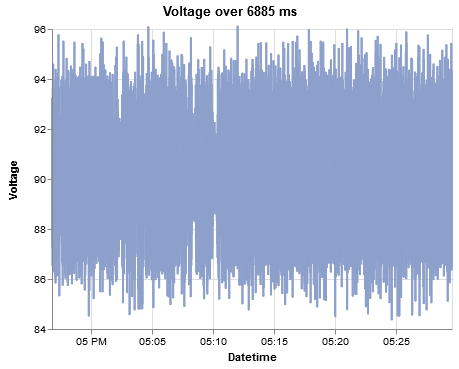

In [6]:
base = alt.Chart().mark_line(color="#8da0cb").encode(
    x = "Datetime:T",
    y = alt.Y("1:Q", title="Voltage", scale = alt.Scale(domain=[84, 96]))
)

alt.layer(base, data = calibrated_data,
          title="Voltage over 6885 ms",
          config={"background": "white"}
         )

Plotting the first 100 samples from the first column gives us a more 

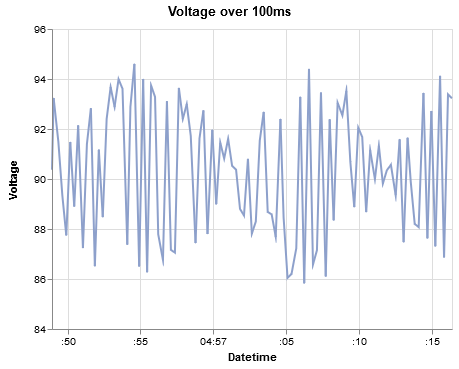

In [7]:
alt.layer(base, data = calibrated_data[:100],
          title="Voltage over 100ms",
          config={"background": "white"}
         )

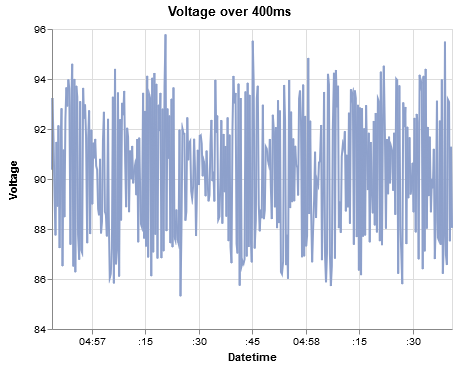

In [8]:
alt.layer(base, data = calibrated_data[:400],
          title="Voltage over 400ms",
          config={"background": "white"}
         )

## Conclusion

It looks like the signal looks like it has a sine wave but it is hard to see.